In [72]:
# Import some libraries

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.datasets as datasets

import os
import pickle
import numpy as np

from PIL import Image
from skimage import io

from matplotlib import pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
input_dim = (3, 256, 306)

In [74]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.Conv2d(96, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(8, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.Conv2d(96, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            Flatten(),
            nn.Linear(in_features=8192, out_features=1024, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=64, bias=True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=64, out_features=1024, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=8192, bias=True),
            DeFlatten(-1, 8, 32, 32),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ConvTranspose2d(8, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding = (1, 1), dilation = (1,1), bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ConvTranspose2d(8, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding = (1, 1), dilation = (1,1), bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        noise = Variable(torch.randn(x.size()) * 0.3)
        noise = noise.to(device)
        x = self.decoder(x + noise)
        return x

model = Autoencoder().to(device)
criterion = nn.MSELoss()

In [75]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

class DeFlatten(nn.Module):
    def __init__(self, *args):
        super(DeFlatten, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [76]:
class EncodingsDataset():
    def __init__(self, artifact_dir, model_file, view, kind, transform):
        self.artifact_dir = artifact_dir
        self.view = view
        self.transform = transform
        
        self.camera_images_dir = os.path.join(artifact_dir, 'data', 'camera_data', kind)
        self.parts_images_dir = os.path.join(artifact_dir, 'data', 'parts_data', kind)

        self.model_dir = os.path.join(artifact_dir, 'models')
        self.model_path = os.path.join(self.model_dir, model_file)

        self.camera_image_names = self._get_camera_images_by_view(self.camera_images_dir, view)
        self.parts_image_names = self._get_camera_images_by_view(self.parts_images_dir, view)
        
        self.encoder = torch.load(self.model_path, map_location={'cuda:0': 'cpu'}).encoder
    
    def __getitem__(self, idx):
        assert self.camera_image_names[idx] == self.parts_image_names[idx]

        camera_image_path = os.path.join(self.camera_images_dir, self.camera_image_names[idx] + '.jpeg')
        parts_image_path = os.path.join(self.parts_images_dir, self.camera_image_names[idx] + '.png')
        model_path = os.path.join(self.model_dir, '')

        camera_image = Image.open(camera_image_path).convert('RGB')
        camera_image = torchvision.transforms.functional.to_tensor(camera_image) 
#         camera_image = camera_image.view(1, *camera_image.shape)

        parts_image = Image.open(parts_image_path).convert('RGB')
        parts_image = torchvision.transforms.functional.to_tensor(parts_image)
#         parts_image = parts_image.view(1, *parts_image.shape)

        #### TODO normalization
        parts_image_1 = parts_image.view(1, *parts_image.shape)
        with torch.no_grad():
            part_encoding = self.encoder(parts_image_1)
        
        part_encoding.view(part_encoding.shape[1])
        
        return self.transform(camera_image), part_encoding

    def __len__(self):
        return len(self.camera_image_names)

    def _get_camera_images_by_view(self, path, view):
        images = list(sorted(os.listdir(path)))
        l = map(lambda name: name.split('.')[0], images)
        l = list(sorted(list(filter(lambda name: name.endswith(view), l))))
        return l
        

In [77]:
batch_size = 32
workers = 2

train_dataset = EncodingsDataset(
    'artifacts',
    'ae_latent_noise_gpu_model_b64_w2_e10.pt',
    'front',
    'train',
    transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
)

val_dataset = EncodingsDataset(
    'artifacts',
    'ae_latent_noise_gpu_model_b64_w2_e10.pt',
    'front',
    'val',
    transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
)


train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=workers, pin_memory=True, sampler=None)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size, shuffle=True,
    num_workers=workers, pin_memory=True)

In [78]:
X, y = iter(train_loader).next()

In [79]:
X.shape

torch.Size([32, 3, 256, 306])

In [80]:
y.view(y.shape[0], y.shape[2]).shape

torch.Size([32, 64])

In [81]:
# import ConvAE_AutoConf as ConvAE

# feature_maps = 96
# depth = 10
# pooling_freq = 2 # large number to disable pooling layers
# batch_norm_freq = 2
# strided_conv_freq = 6
# strided_conv_feature_maps = 32
# code_size = 8

# CONV_ENC_BLOCK = [("conv1", feature_maps), ("relu1", None)]
# CONV_ENC_LAYERS = ConvAE.create_network(
#     CONV_ENC_BLOCK, depth, 
#     pooling_freq=pooling_freq,
#     strided_conv_freq=strided_conv_freq, 
#     strided_conv_channels=strided_conv_feature_maps,
#     batch_norm_freq=batch_norm_freq)

# CONV_ENC_NW = CONV_ENC_LAYERS + [("flatten1", None), ("linear1", 1024), ("relu1", None), ("linear1", 256)]
# model = ConvAE.ConvAE(input_dim, enc_config=CONV_ENC_NW, store_activations=False)
# # print("Encoder Nw Spec:")
# # CONV_ENC_NW
# print(model)

In [82]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [83]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

class DeFlatten(nn.Module):
    def __init__(self, *args):
        super(DeFlatten, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [93]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(96, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(32, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            Flatten(),
            nn.Linear(in_features=1536, out_features=1024, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=256, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=64, bias=True),
        )
    def forward(self, x):
        x = self.encoder(x)
        return x
    
model = CNN().to(device)
criterion = nn.MSELoss()

In [94]:
# from torchsummary import summary

# summary(model, (input_dim))

learning_rate = 1e-1

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [ ]:
from IPython.display import clear_output

num_epochs = 50
dataset_len = len(train_loader.dataset)
val_dataset_len = len(val_loader.dataset)
validation_losses = []
training_losses = []
for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    total = 0
    for data in train_loader:
        img, expected_output = data
        img = img.to(device)
        expected_output = expected_output.to(device)
        # ===================forward=====================
        output = model(img) 
#         output.view(output.shape[0], output.shape[2]).shape
        print(output.shape)
        print(expected_output.shape)
        loss = criterion(output, expected_output)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        clear_output(wait=True)
        total += len(data[0])     
        if len(validation_losses) == 0:
            print(f'epoch [{epoch + 1}/{num_epochs}], data trained:{100 * total / dataset_len :.3f}%, training loss:{loss.item():.4f}')
        else:
            print(f'epoch [{epoch + 1}/{num_epochs}], data trained:{100 * total / dataset_len :.3f}%, training loss:{loss.item():.4f}, validation loss (prev epoch):{validation_losses[-1]}')
    
#     with torch.no_grad():
#         total_vloss = 0
#         for val_data in val_loader:
#             vimg, v_expected_output = val_data
#             vimg = vimg.to(device)
#             voutput = model(vimg)
#             vloss = criterion(voutput, v_expected_output)
#             total_vloss += vloss
#         validation_losses.append(total_vloss)
        
#     with torch.no_grad():
#         total_tloss = 0
#         for train_data in train_loader:
#             timg, t_expected_output = train_data
#             timg = timg.to(device)
#             toutput = model(timg)
#             tloss = criterion(toutput, t_expected_output)
#             total_tloss += tloss
#         training_losses.append(total_tloss)

    if (epoch + 1) % 10 == 0:
        torch.save(model, 'artifacts/models/cnn_gpu_model_b64_w2_e'+ str(epoch + 1) +'.pt')
        model.to(torch.device('cpu'))
        torch.save(model, 'artifacts/models/cnn_cpu_model_b64_w2_e'+ str(epoch + 1) +'.pt')
        model.to(device)

epoch [5/50], data trained:40.822%, training loss:1474.7878


In [16]:
cnn = torch.load('artifacts/models/gpu_model_b64_w2_e30.pt')
cnn = cnn.to(device)
# decoder = torch.load('Models/s_gpu_model_b64_w2_e50.pt').decoder

model = Autoencoder()
model.load_state_dict(torch.load('Models/s_gpu_model_b64_w2_e50.pt'))
decoder = model.decoder

decoder = decoder.to(device)

In [63]:

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Ref: https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())
inv_normalize = NormalizeInverse(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [44]:
from torchvision import utils
def get_results_img(x, nrow=8, padding=5, cnn = True):
# def get_results_img(x, nrow=8, padding=5):
    if cnn:
        return utils.make_grid(
            x.view(-1, *(3, 256, 306)),
            nrow=nrow, padding=padding).permute(1,2,0)
    else:
        return utils.make_grid(
            x.view(-1, *(3, 128, 128)),
            nrow=nrow, padding=padding).permute(1,2,0)

In [45]:
X, y = iter(val_loader).next()
X = X.to(device)
y = y.to(device)

with torch.no_grad():
    out_code = cnn(X).to(device)
    out = decoder(out_code)
    y_out = decoder(y)
    
out_normalized = torch.clamp(
    get_results_img(
        torch.stack([inv_normalize(img.detach()) for img in out]),
        torch.stack([inv_normalize(img.detach()) for img in y_out])
    ), 
    0, 
    1
)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2b7464d795f0>
Traceback (most recent call last):
  File "/home/ns4486/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ns4486/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/ns4486/miniconda3/envs/pytorch/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/ns4486/miniconda3/envs/pytorch/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/ns4486/miniconda3/envs/pytorch/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


RuntimeError: shape '[-1, 3, 256, 306]' is invalid for input of size 1572864

In [ ]:
plt.figure(figsize = (18, 18))
plt.imshow(out_normalized.cpu().detach())

In [83]:
for i in range(3):
    X, y = next(iter(val_loader))
    print(X[0][0][0][0])

tensor(-1.1932)
tensor(2.2489)
tensor(2.2489)


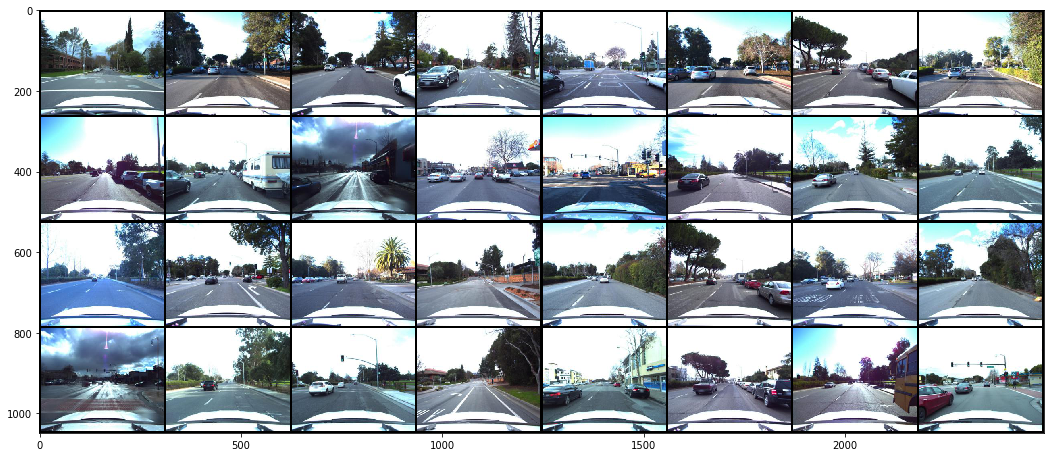

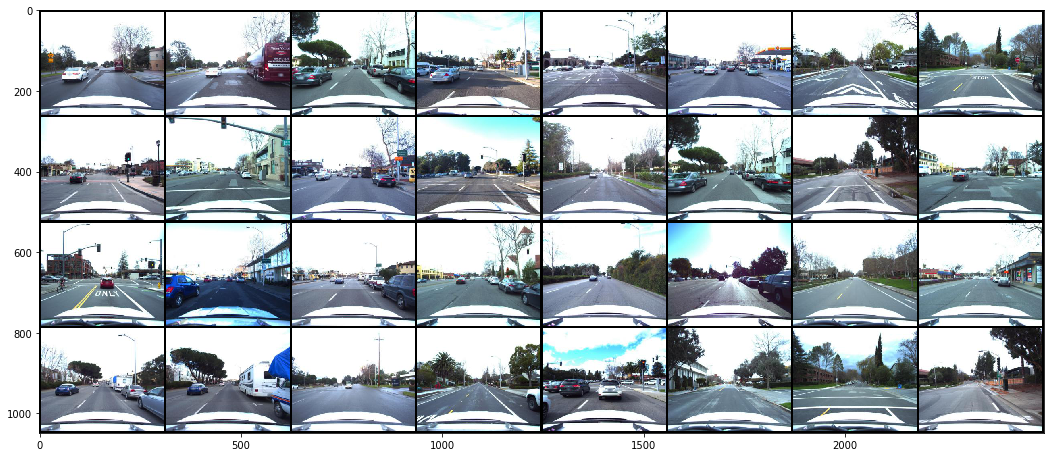

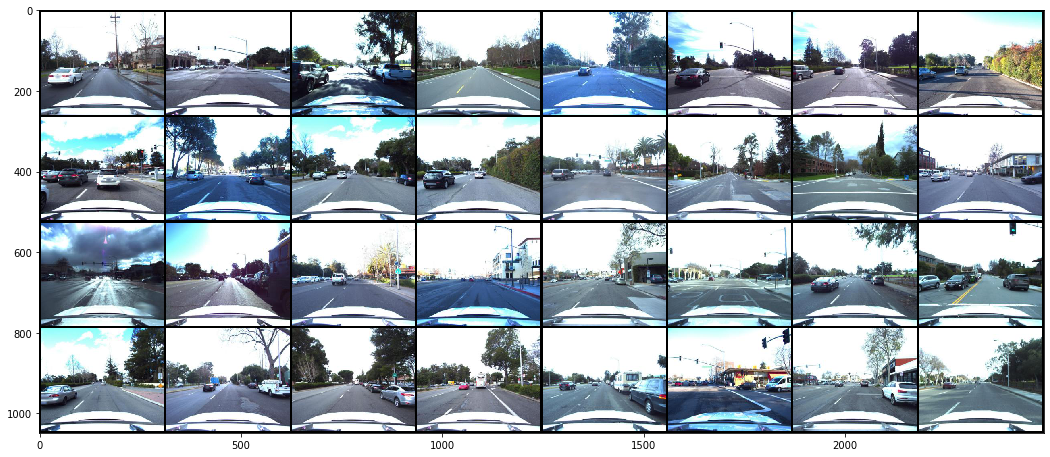

In [46]:
i = 0
for data in val_loader:
    img, expected_output = data
    img = img.to(device)
    
    expected_output = expected_output.to(device)
    out = decoder(expected_output)
    
    out_normalized = torch.clamp(
        get_results_img(
                torch.stack([inv_normalize(img1.detach()) for img1 in img])
            ), 
            0, 
            1
        )
    
    plt.figure(figsize = (18, 18))
    plt.imshow(out_normalized.cpu().detach())
    
    
    i+= 1
    if i==3:
        break

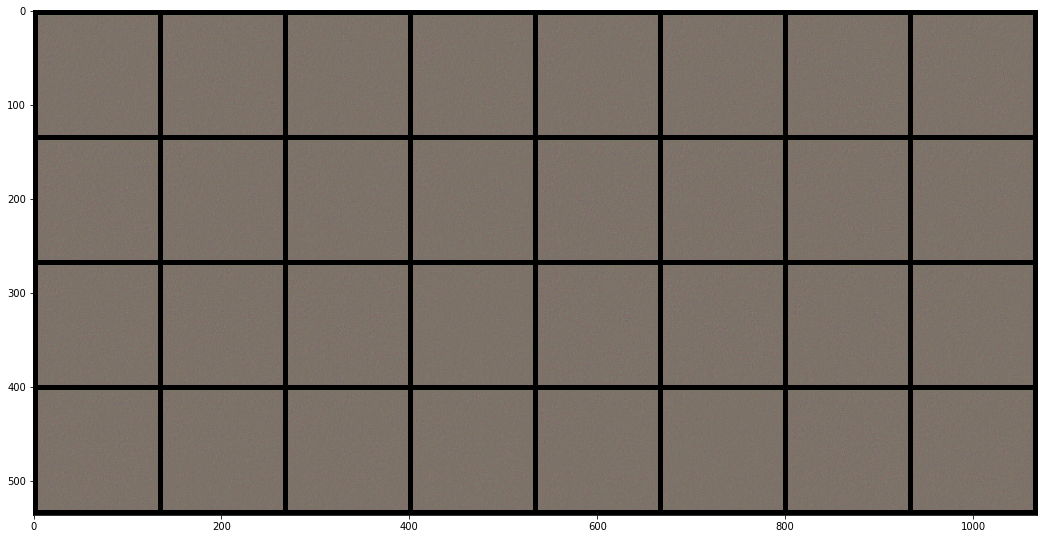

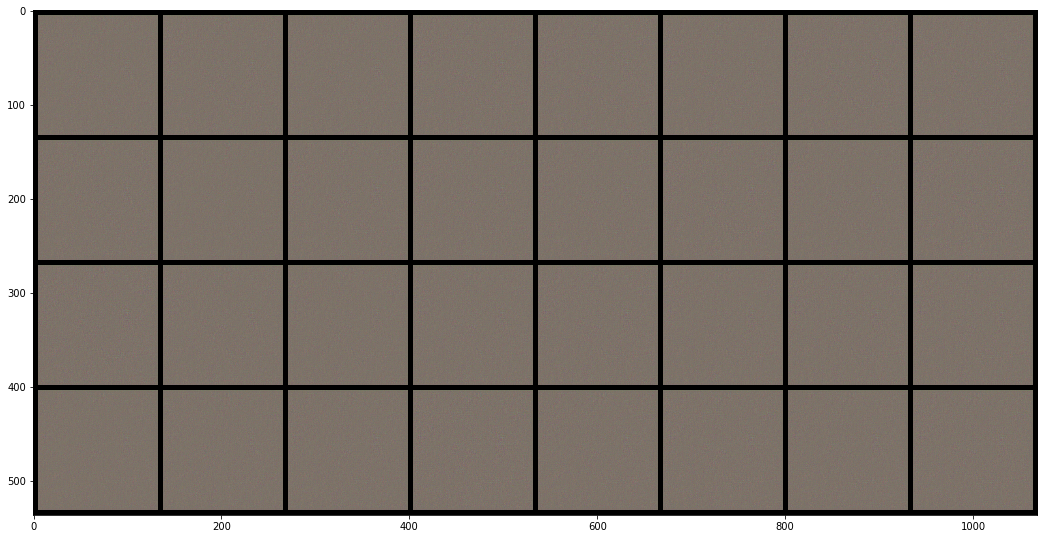

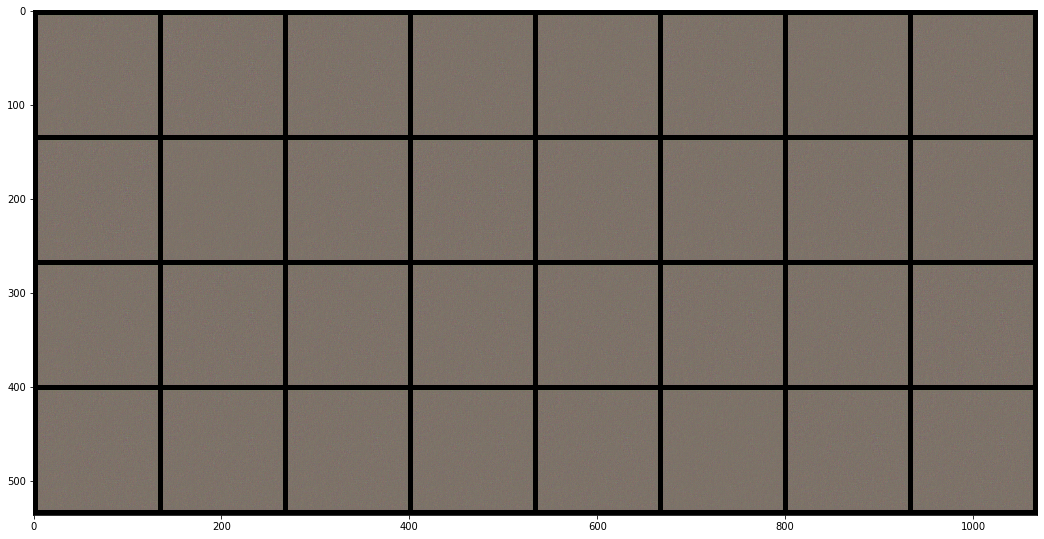

In [47]:
i = 0
for data in val_loader:
    img, expected_output = data
    img = img.to(device)
    
    expected_output = expected_output.to(device)
    
    out = decoder(expected_output)
    
    out_normalized = torch.clamp(
        get_results_img(
                torch.stack([inv_normalize(img1.detach()) for img1 in out]), cnn=False
            ), 
            0, 
            1
        )
    
    plt.figure(figsize = (18, 18))
    plt.imshow(out_normalized.cpu().detach())
    
    
    i+= 1
    if i==3:
        break

In [12]:
cnn = torch.load('artifacts/models/gpu_model_b64_w2_e10.pt')
cnn = cnn.to(device)
# decoder = torch.load('Models/s_gpu_model_b64_w2_e50.pt').decoder

model = Autoencoder()
model.load_state_dict(torch.load('Models/s_gpu_model_b64_w2_e50.pt'))
encoder = model.encoder
decoder = model.decoder

decoder = decoder.to(device)
encoder = encoder.to(device)

In [48]:
camera_image = Image.open('artifacts/data/camera_data/train/108_0_back_right.jpeg').convert('RGB')
camera_image = torchvision.transforms.functional.to_tensor(camera_image) 
#         camera_image = camera_image.view(1, *camera_image.shape)
camera_image = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])(camera_image)
camera_image = camera_image.view(1, *camera_image.shape)
camera_image = camera_image.to(device)

parts_image = Image.open('artifacts/data/parts_data/train/108_0_back_right.png').convert('RGB')
parts_image = torchvision.transforms.functional.to_tensor(parts_image)
parts_image = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])(parts_image)
#         parts_image = parts_image.view(1, *parts_image.shape)
parts_image = parts_image.view(1, *parts_image.shape)
parts_image = parts_image.to(device)

In [49]:
from torchvision import utils
def get_results_img(x, nrow=8, padding=5, cnn = True):
# def get_results_img(x, nrow=8, padding=5):
    if cnn:
        return utils.make_grid(
            x.view(-1, *(3, 256, 306)),
            nrow=nrow, padding=padding).permute(1,2,0)
    else:
        return utils.make_grid(
            x.view(-1, *(3, 128, 128)),
            nrow=nrow, padding=padding).permute(1,2,0)

In [50]:

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Ref: https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())
inv_normalize = NormalizeInverse(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

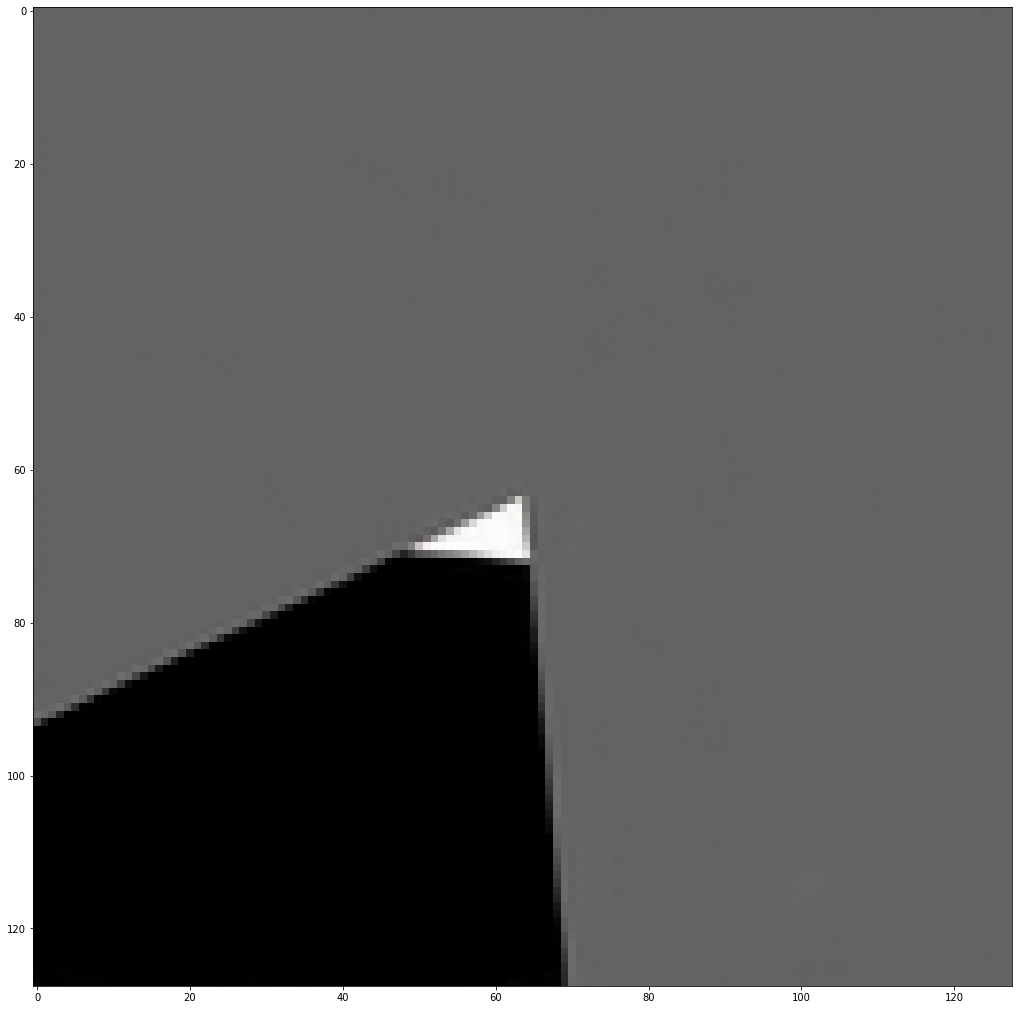

In [51]:
with torch.no_grad():
    code = encoder(parts_image)
    code = code.to(device)
    decoder_output = decoder(code)
    
    out_normalized = torch.clamp(
        get_results_img(
                torch.stack([inv_normalize(img1.detach()) for img1 in decoder_output]), cnn=False
            ),
            0, 
            1
        )
    plt.figure(figsize = (18, 18))
    plt.imshow(out_normalized.cpu().detach())

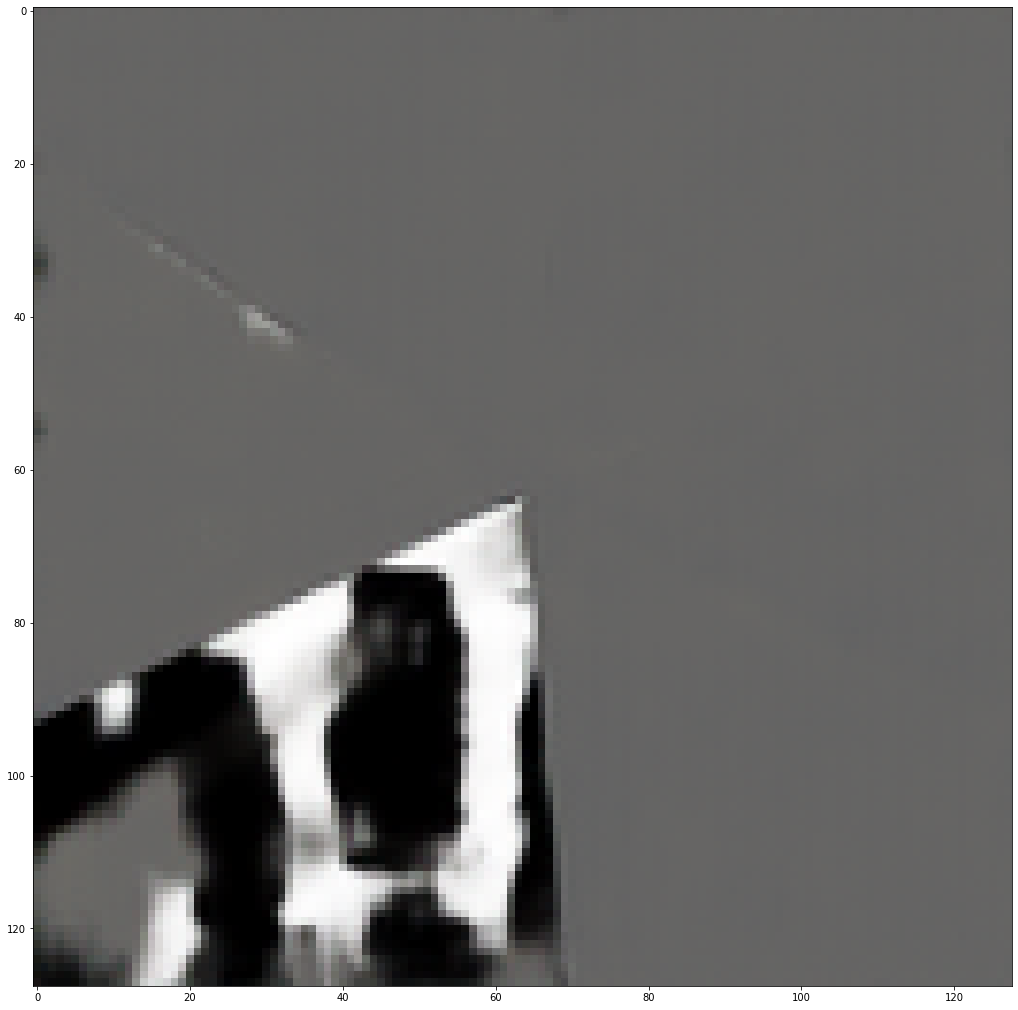

In [52]:
with torch.no_grad():
    code = cnn(camera_image)
    code = code.to(device)
    decoder_output = decoder(code)
    
    out_normalized = torch.clamp(
        get_results_img(
                torch.stack([inv_normalize(img1.detach()) for img1 in decoder_output]), cnn=False
            ),
            0, 
            1
        )
    plt.figure(figsize = (18, 18))
    plt.imshow(out_normalized.cpu().detach())